# 9 Improving performance

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Learning curves

In [2]:
from sklearn.datasets import load_digits

In [3]:
digits = load_digits()

In [4]:
X, y = digits.data, digits.target

In [5]:
X[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [6]:
X.shape

(1797, 64)

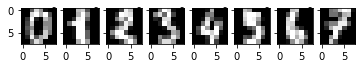

In [7]:
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X.reshape(-1, 8, 8)[i], cmap='gray')

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping

2022-01-17 15:54:56.227629: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-17 15:54:56.227711: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
K.clear_session()

In [10]:
model = Sequential()
model.add(Dense(16, input_shape=(64,), activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

2022-01-17 15:55:00.084241: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-17 15:55:00.084347: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-17 15:55:00.084394: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Manish-S): /proc/driver/nvidia/version does not exist
2022-01-17 15:55:00.085299: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# store the initial random weights
initial_weights = model.get_weights()

In [12]:
y_cat = to_categorical(y, 10)

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat,
                                                    test_size=0.3)

In [15]:
X_train.shape

(1257, 64)

In [16]:
train_sizes = (len(X_train) * np.linspace(0.1, 0.999, 4)).astype(int)
train_sizes

array([ 125,  502,  879, 1255])

In [17]:
train_scores = []
test_scores = []

for train_size in train_sizes:
    X_train_frac, _, y_train_frac, _ = \
    train_test_split(X_train, y_train, train_size=train_size)
    
    # at each iteration reset the weights of the model
    # to the initial random weights
    model.set_weights(initial_weights)
    
    h = model.fit(X_train_frac, y_train_frac,
                  verbose=0,
                  epochs=300,
                  callbacks=[EarlyStopping(monitor='loss', patience=1)])

    r = model.evaluate(X_train_frac, y_train_frac, verbose=0)
    train_scores.append(r[-1])
    
    e = model.evaluate(X_test, y_test, verbose=0)
    test_scores.append(e[-1])
    
    print("Done size: ", train_size)

2022-01-17 15:55:11.168953: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-17 15:55:11.170604: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1799995000 Hz


Done size:  125
Done size:  502
Done size:  879
Done size:  1255


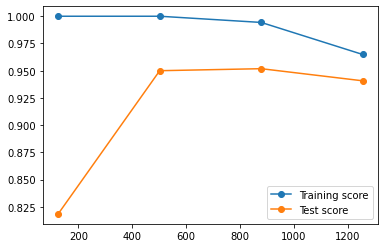

In [18]:
plt.plot(train_sizes, train_scores, 'o-', label="Training score")
plt.plot(train_sizes, test_scores, 'o-', label="Test score")
plt.legend(loc="best")

## Batch Normalization

In [19]:
from tensorflow.keras.layers import BatchNormalization

In [20]:
def repeated_training(X_train,
                      y_train,
                      X_test,
                      y_test,
                      units=512,
                      activation='sigmoid',
                      optimizer='sgd',
                      do_bn=False,
                      epochs=10,
                      repeats=3):
    histories = []
    
    for repeat in range(repeats):
        K.clear_session()

        model = Sequential()
        
        # first fully connected layer
        model.add(Dense(units,
                        input_shape=X_train.shape[1:],
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # second fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # third fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # output layer
        model.add(Dense(10, activation='softmax'))
        
        model.compile(optimizer,
                      'categorical_crossentropy',
                      metrics=['accuracy'])

        h = model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      epochs=epochs,
                      verbose=0)
        histories.append([h.history['accuracy'], h.history['val_accuracy']])
        print(repeat, end=' ')

    histories = np.array(histories)
    
    # calculate mean and standard deviation across repeats:
    mean_acc = histories.mean(axis=0)
    std_acc = histories.std(axis=0)
    print()
    
    return mean_acc[0], std_acc[0], mean_acc[1], std_acc[1]

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
Total params: 1,210
Trainable params: 1,210
Non-trainable params: 0
_________________________________________________________________


In [21]:
mean_acc, std_acc, mean_acc_val, std_acc_val = \
    repeated_training(X_train, y_train, X_test, y_test, do_bn=False)

0 1 2 


In [22]:
mean_acc_bn, std_acc_bn, mean_acc_val_bn, std_acc_val_bn = \
    repeated_training(X_train, y_train, X_test, y_test, do_bn=True)

0 1 2 


In [23]:
def plot_mean_std(m, s):
    plt.plot(m)
    plt.fill_between(range(len(m)), m-s, m+s, alpha=0.1)

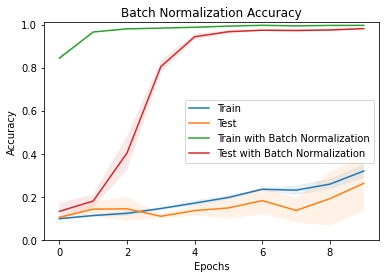

In [24]:
plot_mean_std(mean_acc, std_acc)
plot_mean_std(mean_acc_val, std_acc_val)
plot_mean_std(mean_acc_bn, std_acc_bn)
plot_mean_std(mean_acc_val_bn, std_acc_val_bn)
plt.ylim(0, 1.01)
plt.title("Batch Normalization Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test', 'Train with Batch Normalization', 'Test with Batch Normalization'], loc='best');


## Weight Regularization & Dropout

In [27]:
from tensorflow.keras.layers import Dropout

In [28]:
model = Sequential()
model.add(Dropout(0.2, input_shape=X_train.shape[1:]))
# first fully connected layer
model.add(Dense(512, kernel_initializer='normal',
                kernel_regularizer='l2', activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.compile('sgd',
              'categorical_crossentropy',
              metrics=['accuracy'])

## Data augmentation

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 20,
                               shear_range = 0.3,
                               zoom_range = 0.3,
                               horizontal_flip = True)

In [30]:
train = generator.flow_from_directory('../data/generator',
                                      target_size = (128, 128),
                                      batch_size = 32,
                                      class_mode = 'binary')

Found 1 images belonging to 1 classes.


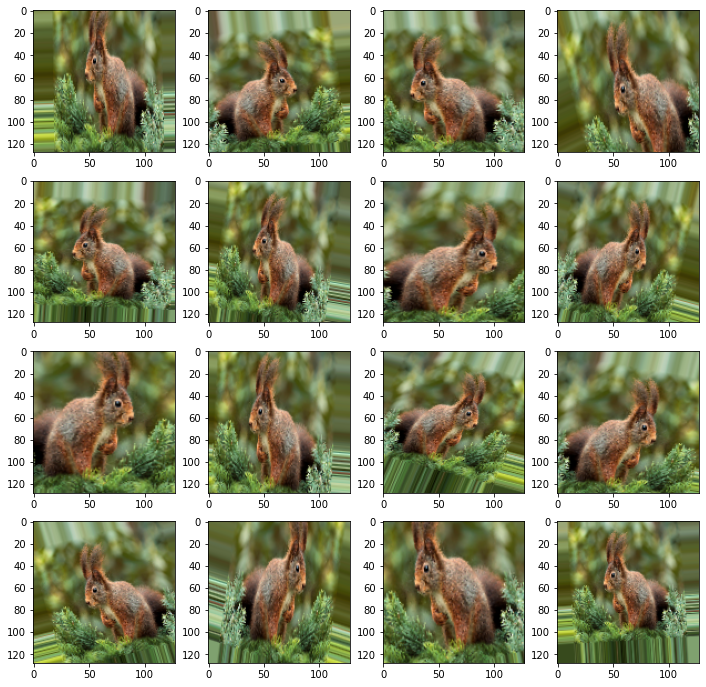

In [31]:
plt.figure(figsize=(12, 12))
for i in range(16):
    img, label = train.next()
    plt.subplot(4, 4, i+1)
    plt.imshow(img[0])

## Embeddings

In [32]:
from tensorflow.keras.layers import Embedding

In [33]:
model = Sequential()
model.add(Embedding(input_dim=100, output_dim=2))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 2)           200       
Total params: 200
Trainable params: 200
Non-trainable params: 0
_________________________________________________________________


In [35]:
emb = model.predict(np.array([[81,  1, 96, 79],
                              [17, 47, 69, 50],
                              [49,  3, 12, 88]]))

In [36]:
emb.shape

(3, 4, 2)

In [37]:
emb

array([[[-0.02235392,  0.03384427],
        [-0.04233055, -0.04080452],
        [-0.04164004,  0.02482801],
        [ 0.04697442, -0.0438971 ]],

       [[ 0.0352501 ,  0.03243387],
        [ 0.04189894, -0.02387734],
        [-0.0318805 ,  0.04017475],
        [-0.04273721,  0.03421924]],

       [[ 0.03344532,  0.0104912 ],
        [-0.02862631,  0.01246135],
        [ 0.00025147,  0.02025557],
        [ 0.0125947 ,  0.038886  ]]], dtype=float32)

## Sentiment prediction on movie Reviews

In [38]:
from tensorflow.keras.datasets import imdb

In [39]:
(X_train, y_train), (X_test, y_test) = imdb.load_data('/tmp/imdb.npz',
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

17465344/17464789 [==============================] - 2s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/manish/anaconda3/envs/ztdl/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/manish/anaconda3/envs/ztdl/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated

In [40]:
X_train.shape

(25000,)

In [41]:
X_train[1]

[1,
 194,
 1153,
 194,
 8255,
 78,
 228,
 5,
 6,
 1463,
 4369,
 5012,
 134,
 26,
 4,
 715,
 8,
 118,
 1634,
 14,
 394,
 20,
 13,
 119,
 954,
 189,
 102,
 5,
 207,
 110,
 3103,
 21,
 14,
 69,
 188,
 8,
 30,
 23,
 7,
 4,
 249,
 126,
 93,
 4,
 114,
 9,
 2300,
 1523,
 5,
 647,
 4,
 116,
 9,
 35,
 8163,
 4,
 229,
 9,
 340,
 1322,
 4,
 118,
 9,
 4,
 130,
 4901,
 19,
 4,
 1002,
 5,
 89,
 29,
 952,
 46,
 37,
 4,
 455,
 9,
 45,
 43,
 38,
 1543,
 1905,
 398,
 4,
 1649,
 26,
 6853,
 5,
 163,
 11,
 3215,
 10156,
 4,
 1153,
 9,
 194,
 775,
 7,
 8255,
 11596,
 349,
 2637,
 148,
 605,
 15358,
 8003,
 15,
 123,
 125,
 68,
 23141,
 6853,
 15,
 349,
 165,
 4362,
 98,
 5,
 4,
 228,
 9,
 43,
 36893,
 1157,
 15,
 299,
 120,
 5,
 120,
 174,
 11,
 220,
 175,
 136,
 50,
 9,
 4373,
 228,
 8255,
 5,
 25249,
 656,
 245,
 2350,
 5,
 4,
 9837,
 131,
 152,
 491,
 18,
 46151,
 32,
 7464,
 1212,
 14,
 9,
 6,
 371,
 78,
 22,
 625,
 64,
 1382,
 9,
 8,
 168,
 145,
 23,
 4,
 1690,
 15,
 16,
 4,
 1355,
 5,
 28,
 6,
 52,
 

In [42]:
idx = imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


In [43]:
max(idx.values())

88584

In [44]:
idx

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [45]:
rev_idx = {v+3:k for k,v in idx.items()}

In [46]:
rev_idx

{34704: 'fawn',
 52009: 'tsukino',
 52010: 'nunnery',
 16819: 'sonja',
 63954: 'vani',
 1411: 'woods',
 16118: 'spiders',
 2348: 'hanging',
 2292: 'woody',
 52011: 'trawling',
 52012: "hold's",
 11310: 'comically',
 40833: 'localized',
 30571: 'disobeying',
 52013: "'royale",
 40834: "harpo's",
 52014: 'canet',
 19316: 'aileen',
 52015: 'acurately',
 52016: "diplomat's",
 25245: 'rickman',
 6749: 'arranged',
 52017: 'rumbustious',
 52018: 'familiarness',
 52019: "spider'",
 68807: 'hahahah',
 52020: "wood'",
 40836: 'transvestism',
 34705: "hangin'",
 2341: 'bringing',
 40837: 'seamier',
 34706: 'wooded',
 52021: 'bravora',
 16820: 'grueling',
 1639: 'wooden',
 16821: 'wednesday',
 52022: "'prix",
 34707: 'altagracia',
 52023: 'circuitry',
 11588: 'crotch',
 57769: 'busybody',
 52024: "tart'n'tangy",
 14132: 'burgade',
 52026: 'thrace',
 11041: "tom's",
 52028: 'snuggles',
 29117: 'francesco',
 52030: 'complainers',
 52128: 'templarios',
 40838: '272',
 52031: '273',
 52133: 'zaniacs',

In [47]:
rev_idx[0] = 'padding_char'
rev_idx[1] = 'start_char'
rev_idx[2] = 'oov_char'
rev_idx[3] = 'unk_char'

In [48]:
rev_idx[3]

'unk_char'

In [49]:
y_train[0]

1

In [50]:
example_review = ' '.join([rev_idx[word] for word in X_train[0]])
example_review

"start_char this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and

In [51]:
len(X_train[0])

218

In [52]:
len(X_train[1])

189

In [53]:
len(X_train[2])

141

In [54]:
len(X_train[3])

550

In [55]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM

In [56]:
maxlen = 100

X_train_pad = pad_sequences(X_train, maxlen=maxlen)
X_test_pad = pad_sequences(X_test, maxlen=maxlen)

In [57]:
X_train_pad.shape

(25000, 100)

In [58]:
X_train_pad[0]

array([ 1415,    33,     6,    22,    12,   215,    28,    77,    52,
           5,    14,   407,    16,    82, 10311,     8,     4,   107,
         117,  5952,    15,   256,     4, 31050,     7,  3766,     5,
         723,    36,    71,    43,   530,   476,    26,   400,   317,
          46,     7,     4, 12118,  1029,    13,   104,    88,     4,
         381,    15,   297,    98,    32,  2071,    56,    26,   141,
           6,   194,  7486,    18,     4,   226,    22,    21,   134,
         476,    26,   480,     5,   144,    30,  5535,    18,    51,
          36,    28,   224,    92,    25,   104,     4,   226,    65,
          16,    38,  1334,    88,    12,    16,   283,     5,    16,
        4472,   113,   103,    32,    15,    16,  5345,    19,   178,
          32], dtype=int32)

In [59]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 22665,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 21631,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 31050,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5

In [60]:
max_features = max([max(x) for x in X_train_pad] + 
                   [max(x) for x in X_test_pad]) + 1
max_features

88587

In [61]:
y_train

array([1, 0, 0, ..., 0, 1, 0])

In [62]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [63]:
model.fit(X_train_pad, y_train,
          batch_size=32,
          epochs=2,
          validation_split=0.3)

Epoch 1/2
547/547 [==============================] - 172s 304ms/step - loss: 0.4307 - accuracy: 0.7993 - val_loss: 0.3705 - val_accuracy: 0.8397
Epoch 2/2
547/547 [==============================] - 170s 310ms/step - loss: 0.1988 - accuracy: 0.9254 - val_loss: 0.4025 - val_accuracy: 0.8459


In [64]:
score, acc = model.evaluate(X_test_pad, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

782/782 [==============================] - 36s 46ms/step - loss: 0.4273 - accuracy: 0.8376
Test score: 0.4272991716861725
Test accuracy: 0.8375599980354309


## Exercise 1

- Reload the IMDB data keeping only the first 20000 most common words
- pad the reviews to a shorter length (eg. 70 or 80), this time make sure you keep the first part of the review if it's longer than the maximum length
- re run the model (remember to set max_features correctly)
- does it train faster this time?
- do you get a better performance?

In [65]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [66]:
max_features = 20000
skip_top = 200

In [67]:
(X_train, y_train), (X_test, y_test) = imdb.load_data('/tmp/imdb.npz',
                                                      num_words=max_features,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/manish/anaconda3/envs/ztdl/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/manish/anaconda3/envs/ztdl/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated

In [68]:
X_train.shape

(25000,)

In [69]:
maxlen = 80

In [70]:
X_train_pad = pad_sequences(X_train, maxlen=maxlen, truncating='post')
X_test_pad = pad_sequences(X_test, maxlen=maxlen, truncating='post')

In [71]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [72]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,

In [73]:
model.fit(X_train_pad, y_train,
          batch_size=32,
          epochs=2,
          validation_split=0.3)

Epoch 1/2
547/547 [==============================] - 108s 191ms/step - loss: 0.5161 - accuracy: 0.7368 - val_loss: 0.4178 - val_accuracy: 0.8120
Epoch 2/2
547/547 [==============================] - 106s 193ms/step - loss: 0.3032 - accuracy: 0.8776 - val_loss: 0.4208 - val_accuracy: 0.8112


In [76]:
score, acc = model.evaluate(X_test_pad, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

782/782 [==============================] - 31s 40ms/step - loss: 0.4832 - accuracy: 0.7760
Test score: 0.48321789503097534
Test accuracy: 0.7760400176048279


## Exercise 2

- Reload the digits data as above
- define a function repeated_training_reg_dropout that adds regularization and dropout to a fully connected network
- compare the performance with/witouth dropout and regularization like we did for batch normalization
- do you get a better performance?

In [77]:
from sklearn.datasets import load_digits
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
import tensorflow.keras.backend as K

In [78]:
digits = load_digits()
X, y = digits.data, digits.target
y_cat = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3)

In [79]:
def repeated_training_reg_dropout(X_train,
                                  y_train,
                                  X_test,
                                  y_test,
                                  units=512,
                                  activation='sigmoid',
                                  optimizer='sgd',
                                  do_dropout=False,
                                  rate=0.3,
                                  kernel_regularizer='l2',
                                  epochs=10,
                                  repeats=3):
    histories = []
    
    for repeat in range(repeats):
        K.clear_session()

        model = Sequential()
        
        # first fully connected layer
        model.add(Dense(units,
                        input_shape=X_train.shape[1:],
                        kernel_initializer='normal',
                        kernel_regularizer=kernel_regularizer,
                        activation=activation))
        if do_dropout:
            model.add(Dropout(rate))

        # second fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        kernel_regularizer=kernel_regularizer,
                        activation=activation))
        if do_dropout:
            model.add(Dropout(rate))

        # third fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        kernel_regularizer=kernel_regularizer,
                        activation=activation))
        if do_dropout:
            model.add(Dropout(rate))

        # output layer
        model.add(Dense(10, activation='softmax'))
        
        model.compile(optimizer,
                      'categorical_crossentropy',
                      metrics=['accuracy'])

        h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0)
        histories.append([h.history['accuracy'], h.history['val_accuracy']])
        print(repeat, end=' ')

    histories = np.array(histories)
    
    # calculate mean and standard deviation across repeats:
    mean_acc = histories.mean(axis=0)
    std_acc = histories.std(axis=0)
    print()
    
    return mean_acc[0], std_acc[0], mean_acc[1], std_acc[1]

In [80]:
mean_acc, std_acc, mean_acc_val, std_acc_val = repeated_training_reg_dropout(X_train,
                                                                             y_train,
                                                                             X_test,
                                                                             y_test,
                                                                             do_dropout=False)

0 1 2 


In [81]:
mean_acc_do, std_acc_do, mean_acc_val_do, std_acc_val_do = repeated_training_reg_dropout(X_train,
                                                                                         y_train,
                                                                                         X_test,
                                                                                         y_test,
                                                                                         do_dropout=True)

0 1 2 


In [82]:
def plot_mean_std(m, s):
    plt.plot(m)
    plt.fill_between(range(len(m)), m-s, m+s, alpha=0.1)

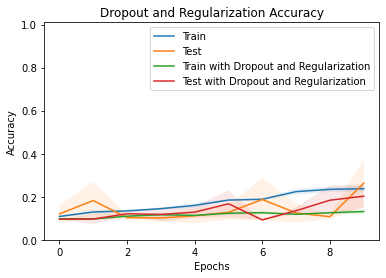

In [83]:
plot_mean_std(mean_acc, std_acc)
plot_mean_std(mean_acc_val, std_acc_val)
plot_mean_std(mean_acc_do, std_acc_do)
plot_mean_std(mean_acc_val_do, std_acc_val_do)
plt.ylim(0, 1.01)
plt.title("Dropout and Regularization Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test', 'Train with Dropout and Regularization', 'Test with Dropout and Regularization'], loc='best')

## Exercise 3

This is a very long and complex exercise, that should give you an idea of a real world scenario. Feel free to look at the solution if you feel lost. Also, feel free to run this on Floyd with a GPU, in which case you don't need to download the data.

If you are running this locally, download and unpack the male/female pictures from [here](https://www.dropbox.com/s/nov493om2jmh2gp/male_female.tgz?dl=0). These images and labels were obtained from [Crowdflower](https://www.crowdflower.com/data-for-everyone/).

Your goal is to build an image classifier that will recognize the gender of a person from pictures.

- Have a look at the directory structure and inspect a couple of pictures
- Design a model that will take a color image of size 64x64 as input and return a binary output (female=0/male=1)
- Feel free to introduce any regularization technique in your model (Dropout, Batch Normalization, Weight Regularization)
- Compile your model with an optimizer of your choice
- Using `ImageDataGenerator`, define a train generator that will augment your images with some geometric transformations. Feel free to choose the parameters that make sense to you.
- Define also a test generator, whose only purpose is to rescale the pixels by 1./255
- use the function `flow_from_directory` to generate batches from the train and test folders. Make sure you set the `target_size` to 64x64.
- Use the `model.fit_generator` function to fit the model on the batches generated from the ImageDataGenerator. Since you are streaming and augmenting the data in real time you will have to decide how many batches make an epoch and how many epochs you want to run
- Train your model (you should get to at least 85% accuracy)
- Once you are satisfied with your training, check a few of the misclassified pictures. Are those sensible errors?

In [90]:

# If you are running this locally
# uncomment the next 4 lines to download, extract and set the data path:
!wget 'https://www.dropbox.com/s/nov493om2jmh2gp/male_female.tgz?dl=1' -O ../data/male_female.tgz
data_path = '../data/male_female/'
!mkdir -p {data_path}
!tar -xzvf ../data/male_female.tgz --directory {data_path}


--2022-01-18 10:47:53--  https://www.dropbox.com/s/nov493om2jmh2gp/male_female.tgz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/nov493om2jmh2gp/male_female.tgz [following]
--2022-01-18 10:47:54--  https://www.dropbox.com/s/dl/nov493om2jmh2gp/male_female.tgz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8de05adef6cb101e307b0ca926.dl.dropboxusercontent.com/cd/0/get/Bd-1kfCwcFU4-ZvWLhP_WtngAjtHXQmLOlUCKvJwjYo4vCuLmreBE7Lh1XFFgyIWKtzFFpVVaLZbWlgumIyTF77uZ8lwENqfP0_Sz_qNfnnTFrE6GRh36PcUPOaJ6CG9TwtCyC6vFh39mULNG1OPOU68/file?dl=1# [following]
--2022-01-18 10:47:55--  https://uc8de05adef6cb101e307b0ca926.dl.dropboxusercontent.com/cd/0/get/Bd-1kfCwcFU4-ZvWLhP_WtngAjtHXQmLOlUCKvJwjYo4vCuLmreBE7Lh1XFFgyIWKtzFFpVVaLZb

data/test/1_male/498248-large.jpg
data/test/1_male/71593-large.jpg
data/test/1_male/480994-large.jpg
data/test/1_male/358312-large.jpg
data/test/1_male/37164-large.jpg
data/test/1_male/1277429-large.jpg
data/test/1_male/412605-large.jpg
data/test/1_male/994392-large.jpg
data/test/1_male/275350-large.jpg
data/test/1_male/142515-large.jpg
data/test/1_male/493822-large.jpg
data/test/1_male/145289-large.jpg
data/test/1_male/647135-large.jpg
data/test/1_male/570842-large.jpg
data/test/1_male/289610-large.jpg
data/test/1_male/164802-large.jpg
data/test/1_male/88586-large.jpg
data/test/1_male/1317163-large.jpg
data/test/1_male/1655778-large.jpg
data/test/1_male/1350117-large.jpg
data/test/1_male/9544-large.jpg
data/test/1_male/245904-large.jpg
data/test/1_male/174658-large.jpg
data/test/1_male/1428605-large.jpg
data/test/1_male/1062621-large.jpg
data/test/1_male/386535-large.jpg
data/test/1_male/86538-large.png
data/test/1_male/907181-large.jpg
data/test/1_male/1596121-large.jpg
data/test/1_m

data/test/1_male/514255-large.png
data/test/1_male/1566169-large.jpg
data/test/1_male/710529-large.jpg
data/test/1_male/347690-large.jpg
data/test/1_male/120856-large.jpg
data/test/1_male/103660-large.jpg
data/test/1_male/65940-large.jpg
data/test/1_male/1264320-large.jpg
data/test/1_male/53457-large.jpg
data/test/1_male/515964-large.jpg
data/test/1_male/979774-large.jpg
data/test/1_male/1676290-large.jpg
data/test/1_male/298781-large.jpg
data/test/1_male/510206-large.jpg
data/test/1_male/495184-large.jpg
data/test/1_male/513-large.jpg
data/test/1_male/18442-large.jpg
data/test/1_male/212347-large.jpg
data/test/1_male/460248-large.jpg
data/test/1_male/576549-large.jpg
data/test/1_male/119272-large.jpg
data/test/1_male/418024-large.jpg
data/test/1_male/1190993-large.png
data/test/1_male/733485-large.jpg
data/test/1_male/1261169-large.jpg
data/test/1_male/831829-large.jpg
data/test/1_male/109220-large.jpg
data/test/1_male/375226-large.jpg
data/test/1_male/1430890-large.png
data/test/1_ma

data/test/1_male/992061-large.jpg
data/test/1_male/206132-large.jpg
data/test/1_male/1205966-large.png
data/test/1_male/1607625-large.png
data/test/1_male/396213-large.jpg
data/test/1_male/155009-large.jpg
data/test/1_male/294225-large.jpg
data/test/1_male/38510-large.jpg
data/test/1_male/114216-large.jpg
data/test/1_male/65041-large.jpg
data/test/1_male/4744-large.jpg
data/test/1_male/1481000-large.jpg
data/test/1_male/71403-large.jpg
data/test/1_male/281351-large.jpg
data/test/1_male/72342-large.jpg
data/test/1_male/491022-large.jpg
data/test/1_male/1368585-large.jpg
data/test/1_male/1238464-large.jpg
data/test/1_male/80596-large.jpg
data/test/1_male/361767-large.jpg
data/test/1_male/539472-large.jpg
data/test/1_male/86699-large.jpg
data/test/1_male/1166750-large.jpg
data/test/1_male/80218-large.jpg
data/test/1_male/595315-large.jpg
data/test/1_male/1239705-large.jpg
data/test/1_male/13696-large.png
data/test/1_male/279708-large.png
data/test/1_male/1194702-large.jpg
data/test/1_male

data/test/1_male/342154-large.jpg
data/test/1_male/469770-large.jpg
data/test/1_male/201166-large.jpg
data/test/1_male/1252684-large.jpg
data/test/1_male/453018-large.jpg
data/test/1_male/246040-large.png
data/test/1_male/952683-large.jpg
data/test/1_male/140567-large.jpg
data/test/1_male/579924-large.jpg
data/test/1_male/1485808-large.jpg
data/test/1_male/505052-large.jpg
data/test/1_male/507403-large.jpg
data/test/1_male/48622-large.png
data/test/1_male/1345601-large.png
data/test/1_male/538075-large.jpg
data/test/1_male/1414389-large.jpg
data/test/1_male/60758-large.jpg
data/test/1_male/200581-large.jpg
data/test/1_male/1598855-large.jpg
data/test/1_male/969370-large.jpg
data/test/1_male/301715-large.jpg
data/test/1_male/6738-large.jpg
data/test/1_male/91731-large.jpg
data/test/1_male/649716-large.jpg
data/test/1_male/66132-large.jpg
data/test/1_male/924032-large.jpg
data/test/1_male/1321255-large.jpg
data/test/1_male/679488-large.jpg
data/test/1_male/94365-large.jpg
data/test/1_mal

data/test/1_male/48191-large.jpg
data/test/1_male/448517-large.png
data/test/1_male/501986-large.jpg
data/test/1_male/1571609-large.png
data/test/1_male/320963-large.jpg
data/test/1_male/120838-large.jpg
data/test/1_male/82614-large.jpg
data/test/1_male/521866-large.jpg
data/test/1_male/302647-large.jpg
data/test/1_male/1453489-large.jpg
data/test/1_male/109909-large.jpg
data/test/1_male/219452-large.jpg
data/test/1_male/90508-large.jpg
data/test/1_male/115353-large.jpg
data/test/1_male/665356-large.jpg
data/test/1_male/538805-large.jpg
data/test/1_male/1064061-large.jpg
data/test/1_male/211724-large.jpg
data/test/1_male/487156-large.jpg
data/test/1_male/418867-large.jpg
data/test/1_male/221965-large.jpg
data/test/1_male/504006-large.jpg
data/test/1_male/375607-large.jpg
data/test/1_male/174540-large.jpg
data/test/1_male/608895-large.jpg
data/test/1_male/122291-large.jpg
data/test/1_male/333574-large.jpg
data/test/1_male/388660-large.jpg
data/test/1_male/218708-large.png
data/test/1_ma

data/test/0_female/522724-large.jpg
data/test/0_female/796493-large.png
data/test/0_female/735303-large.jpg
data/test/0_female/631940-large.jpg
data/test/0_female/1257255-large.jpg
data/test/0_female/732830-large.jpg
data/test/0_female/1090957-large.jpg
data/test/0_female/155049-large.png
data/test/0_female/1562398-large.jpg
data/test/0_female/403875-large.jpg
data/test/0_female/950190-large.jpg
data/test/0_female/1156149-large.jpg
data/test/0_female/119676-large.jpg
data/test/0_female/443754-large.jpg
data/test/0_female/122777-large.jpg
data/test/0_female/916784-large.jpg
data/test/0_female/625817-large.jpg
data/test/0_female/993804-large.jpg
data/test/0_female/1593838-large.jpg
data/test/0_female/106536-large.jpg
data/test/0_female/1065831-large.jpg
data/test/0_female/562502-large.jpg
data/test/0_female/447613-large.jpg
data/test/0_female/39496-large.png
data/test/0_female/163883-large.jpg
data/test/0_female/496893-large.jpg
data/test/0_female/79595-large.jpg
data/test/0_female/97534

data/test/0_female/1410093-large.jpg
data/test/0_female/582556-large.jpg
data/test/0_female/63432-large.jpg
data/test/0_female/38625-large.jpg
data/test/0_female/424606-large.png
data/test/0_female/660202-large.jpg
data/test/0_female/1156715-large.jpg
data/test/0_female/785695-large.jpg
data/test/0_female/216929-large.jpg
data/test/0_female/661667-large.jpg
data/test/0_female/1169992-large.jpg
data/test/0_female/1546993-large.jpg
data/test/0_female/170573-large.jpg
data/test/0_female/1605266-large.jpg
data/test/0_female/1157303-large.jpg
data/test/0_female/790930-large.jpg
data/test/0_female/228559-large.jpg
data/test/0_female/1032458-large.jpg
data/test/0_female/241082-large.jpg
data/test/0_female/715322-large.jpg
data/test/0_female/1395232-large.jpg
data/test/0_female/201355-large.jpg
data/test/0_female/726435-large.jpg
data/test/0_female/1286250-large.jpg
data/test/0_female/358914-large.jpg
data/test/0_female/1511269-large.jpg
data/test/0_female/1381393-large.jpg
data/test/0_female/

data/test/0_female/91644-large.jpg
data/test/0_female/467506-large.jpg
data/test/0_female/61042-large.jpg
data/test/0_female/217206-large.jpg
data/test/0_female/83220-large.jpg
data/test/0_female/601526-large.png
data/test/0_female/84620-large.jpg
data/test/0_female/345346-large.jpg
data/test/0_female/921579-large.jpg
data/test/0_female/1383029-large.jpg
data/test/0_female/1164057-large.jpg
data/test/0_female/483440-large.jpg
data/test/0_female/1019822-large.jpg
data/test/0_female/1298123-large.jpg
data/test/0_female/1000503-large.jpg
data/test/0_female/324453-large.jpg
data/test/0_female/21713-large.png
data/test/0_female/1012078-large.jpg
data/test/0_female/392688-large.jpg
data/test/0_female/129722-large.jpg
data/test/0_female/98126-large.jpg
data/test/0_female/1103463-large.jpg
data/test/0_female/366037-large.jpg
data/test/0_female/1228167-large.png
data/test/0_female/714980-large.jpg
data/test/0_female/743923-large.png
data/test/0_female/38026-large.jpg
data/test/0_female/241711-l

data/test/0_female/107202-large.png
data/test/0_female/919060-large.jpg
data/test/0_female/671069-large.jpg
data/test/0_female/698677-large.jpg
data/test/0_female/268642-large.jpg
data/test/0_female/1053218-large.jpg
data/test/0_female/423267-large.jpg
data/test/0_female/109536-large.jpg
data/test/0_female/1664267-large.jpg
data/test/0_female/992663-large.jpg
data/test/0_female/473148-large.jpg
data/test/0_female/295012-large.jpg
data/test/0_female/702102-large.jpg
data/test/0_female/523784-large.jpg
data/test/0_female/264581-large.jpg
data/test/0_female/131267-large.jpg
data/test/0_female/520406-large.jpg
data/test/0_female/54802-large.jpg
data/test/0_female/265430-large.jpg
data/test/0_female/535146-large.jpg
data/test/0_female/630992-large.png
data/test/0_female/254577-large.jpg
data/test/0_female/45642-large.jpg
data/test/0_female/218691-large.jpg
data/test/0_female/26972-large.jpg
data/test/0_female/169345-large.jpg
data/test/0_female/71450-large.jpg
data/test/0_female/634429-larg

data/test/0_female/1056948-large.jpg
data/test/0_female/167845-large.jpg
data/test/0_female/465708-large.jpg
data/test/0_female/303988-large.jpg
data/test/0_female/5332-large.png
data/test/0_female/126878-large.jpg
data/test/0_female/304017-large.jpg
data/test/0_female/340147-large.jpg
data/test/0_female/644460-large.jpg
data/test/0_female/578879-large.jpg
data/test/0_female/1452186-large.jpg
data/test/0_female/91845-large.jpg
data/test/0_female/649133-large.jpg
data/test/0_female/17741-large.png
data/test/0_female/85377-large.jpg
data/test/0_female/285996-large.jpg
data/test/0_female/736395-large.jpg
data/test/0_female/523625-large.jpg
data/test/0_female/511994-large.jpg
data/test/0_female/424537-large.jpg
data/test/0_female/647736-large.jpg
data/test/0_female/413649-large.jpg
data/test/0_female/1316598-large.jpg
data/test/0_female/159160-large.jpg
data/test/0_female/1220561-large.jpg
data/test/0_female/66648-large.jpg
data/test/0_female/882265-large.jpg
data/test/0_female/493388-larg

data/test/0_female/97104-large.jpg
data/test/0_female/254516-large.jpg
data/test/0_female/295609-large.png
data/test/0_female/820583-large.jpg
data/test/0_female/396453-large.jpg
data/test/0_female/600495-large.jpg
data/test/0_female/34293-large.jpg
data/test/0_female/100012-large.jpg
data/test/0_female/90381-large.png
data/test/0_female/472267-large.jpg
data/test/0_female/352471-large.jpg
data/test/0_female/740834-large.jpg
data/test/0_female/428441-large.jpg
data/test/0_female/1179423-large.jpg
data/test/0_female/1206250-large.jpg
data/test/0_female/1383671-large.jpg
data/test/0_female/150222-large.jpg
data/test/0_female/303880-large.jpg
data/test/0_female/668384-large.jpg
data/test/0_female/787191-large.jpg
data/test/0_female/311236-large.jpg
data/test/0_female/480366-large.jpg
data/test/0_female/259327-large.jpg
data/test/0_female/36964-large.jpg
data/test/0_female/630141-large.jpg
data/test/0_female/296251-large.jpg
data/test/0_female/407197-large.jpg
data/test/0_female/181674-lar

data/train/1_male/383008-large.jpg
data/train/1_male/614550-large.jpg
data/train/1_male/1043073-large.jpg
data/train/1_male/88530-large.jpg
data/train/1_male/1114503-large.jpg
data/train/1_male/68450-large.jpg
data/train/1_male/233143-large.jpg
data/train/1_male/41876-large.jpg
data/train/1_male/339724-large.jpg
data/train/1_male/1239271-large.jpg
data/train/1_male/43295-large.jpg
data/train/1_male/956020-large.jpg
data/train/1_male/209895-large.jpg
data/train/1_male/96755-large.jpg
data/train/1_male/346302-large.jpg
data/train/1_male/70427-large.jpg
data/train/1_male/1539227-large.jpg
data/train/1_male/118564-large.jpg
data/train/1_male/395869-large.jpg
data/train/1_male/165707-large.jpg
data/train/1_male/63247-large.jpg
data/train/1_male/591134-large.jpg
data/train/1_male/53046-large.jpg
data/train/1_male/147857-large.jpg
data/train/1_male/828180-large.jpg
data/train/1_male/86961-large.jpg
data/train/1_male/763354-large.jpg
data/train/1_male/1437251-large.jpg
data/train/1_male/167781

data/train/1_male/81749-large.jpg
data/train/1_male/471914-large.jpg
data/train/1_male/685536-large.jpg
data/train/1_male/1117565-large.jpg
data/train/1_male/83044-large.jpg
data/train/1_male/581864-large.jpg
data/train/1_male/733277-large.jpg
data/train/1_male/168137-large.jpg
data/train/1_male/735996-large.jpg
data/train/1_male/663129-large.jpg
data/train/1_male/876713-large.png
data/train/1_male/164167-large.jpg
data/train/1_male/222066-large.jpg
data/train/1_male/516396-large.jpg
data/train/1_male/237790-large.jpg
data/train/1_male/882629-large.jpg
data/train/1_male/421397-large.jpg
data/train/1_male/732710-large.jpg
data/train/1_male/1481828-large.jpg
data/train/1_male/784721-large.jpg
data/train/1_male/93012-large.png
data/train/1_male/251966-large.jpg
data/train/1_male/155596-large.jpg
data/train/1_male/459855-large.jpg
data/train/1_male/875865-large.jpg
data/train/1_male/135534-large.png
data/train/1_male/119069-large.jpg
data/train/1_male/1392908-large.jpg
data/train/1_male/38

data/train/1_male/871664-large.jpg
data/train/1_male/106354-large.jpg
data/train/1_male/1015196-large.jpg
data/train/1_male/565213-large.png
data/train/1_male/1293885-large.jpg
data/train/1_male/1115419-large.jpg
data/train/1_male/304154-large.jpg
data/train/1_male/534319-large.jpg
data/train/1_male/868959-large.jpg
data/train/1_male/31786-large.jpg
data/train/1_male/8202-large.jpg
data/train/1_male/57863-large.jpg
data/train/1_male/5837-large.jpg
data/train/1_male/108263-large.jpg
data/train/1_male/175438-large.jpg
data/train/1_male/4522-large.jpg
data/train/1_male/301722-large.jpg
data/train/1_male/908031-large.jpg
data/train/1_male/475873-large.png
data/train/1_male/464757-large.jpg
data/train/1_male/92374-large.jpg
data/train/1_male/1076897-large.jpg
data/train/1_male/291624-large.jpg
data/train/1_male/156519-large.jpg
data/train/1_male/131798-large.jpg
data/train/1_male/128029-large.jpg
data/train/1_male/123241-large.jpg
data/train/1_male/719092-large.jpg
data/train/1_male/852627-

data/train/1_male/49209-large.png
data/train/1_male/392458-large.jpg
data/train/1_male/315597-large.jpg
data/train/1_male/110061-large.jpg
data/train/1_male/1243765-large.jpg
data/train/1_male/813632-large.jpg
data/train/1_male/177392-large.jpg
data/train/1_male/369647-large.jpg
data/train/1_male/3572-large.jpg
data/train/1_male/461474-large.jpg
data/train/1_male/93477-large.jpg
data/train/1_male/332800-large.jpg
data/train/1_male/359843-large.jpg
data/train/1_male/104838-large.jpg
data/train/1_male/129545-large.jpg
data/train/1_male/154387-large.jpg
data/train/1_male/35056-large.jpg
data/train/1_male/1409766-large.jpg
data/train/1_male/876908-large.jpg
data/train/1_male/736431-large.jpg
data/train/1_male/945426-large.png
data/train/1_male/1379127-large.jpg
data/train/1_male/1155979-large.jpg
data/train/1_male/352518-large.jpg
data/train/1_male/962210-large.jpg
data/train/1_male/1035316-large.jpg
data/train/1_male/277259-large.jpg
data/train/1_male/134968-large.jpg
data/train/1_male/14

data/train/1_male/241532-large.jpg
data/train/1_male/318603-large.jpg
data/train/1_male/916280-large.jpg
data/train/1_male/1424625-large.jpg
data/train/1_male/96683-large.jpg
data/train/1_male/319751-large.png
data/train/1_male/147788-large.png
data/train/1_male/1227664-large.jpg
data/train/1_male/23548-large.jpg
data/train/1_male/411420-large.jpg
data/train/1_male/729254-large.jpg
data/train/1_male/1210248-large.jpg
data/train/1_male/483772-large.jpg
data/train/1_male/528544-large.jpg
data/train/1_male/132850-large.png
data/train/1_male/886632-large.jpg
data/train/1_male/1153436-large.jpg
data/train/1_male/180683-large.jpg
data/train/1_male/1229405-large.jpg
data/train/1_male/44842-large.jpg
data/train/1_male/64695-large.jpg
data/train/1_male/818759-large.jpg
data/train/1_male/1187819-large.jpg
data/train/1_male/211001-large.jpg
data/train/1_male/308975-large.jpg
data/train/1_male/1001519-large.jpg
data/train/1_male/953198-large.jpg
data/train/1_male/461159-large.jpg
data/train/1_male

data/train/1_male/872730-large.jpg
data/train/1_male/737719-large.jpg
data/train/1_male/258651-large.jpg
data/train/1_male/58465-large.jpg
data/train/1_male/957444-large.jpg
data/train/1_male/574813-large.jpg
data/train/1_male/557243-large.jpg
data/train/1_male/478969-large.jpg
data/train/1_male/561999-large.jpg
data/train/1_male/179182-large.jpg
data/train/1_male/388748-large.jpg
data/train/1_male/143360-large.jpg
data/train/1_male/144751-large.jpg
data/train/1_male/578261-large.jpg
data/train/1_male/592686-large.jpg
data/train/1_male/1588161-large.png
data/train/1_male/188387-large.jpg
data/train/1_male/561500-large.jpg
data/train/1_male/161489-large.jpg
data/train/1_male/295978-large.jpg
data/train/1_male/179936-large.jpg
data/train/1_male/575594-large.jpg
data/train/1_male/2246-large.jpg
data/train/1_male/237266-large.jpg
data/train/1_male/181218-large.jpg
data/train/1_male/971480-large.jpg
data/train/1_male/208721-large.jpg
data/train/1_male/177065-large.jpg
data/train/1_male/1214

data/train/1_male/101893-large.jpg
data/train/1_male/293995-large.jpg
data/train/1_male/1642651-large.jpg
data/train/1_male/75245-large.jpg
data/train/1_male/1648354-large.jpg
data/train/1_male/42072-large.jpg
data/train/1_male/720641-large.jpg
data/train/1_male/7879-large.jpg
data/train/1_male/576717-large.png
data/train/1_male/530394-large.jpg
data/train/1_male/321967-large.jpg
data/train/1_male/171186-large.jpg
data/train/1_male/202030-large.jpg
data/train/1_male/1280626-large.jpg
data/train/1_male/22951-large.jpg
data/train/1_male/366934-large.jpg
data/train/1_male/756565-large.jpg
data/train/1_male/1593837-large.jpg
data/train/1_male/858280-large.jpg
data/train/1_male/750642-large.jpg
data/train/1_male/572398-large.jpg
data/train/1_male/578485-large.jpg
data/train/1_male/285595-large.jpg
data/train/1_male/644272-large.jpg
data/train/1_male/762869-large.jpg
data/train/1_male/1627373-large.jpg
data/train/1_male/302072-large.png
data/train/1_male/835100-large.png
data/train/1_male/51

data/train/1_male/413685-large.jpg
data/train/1_male/72164-large.jpg
data/train/1_male/167280-large.jpg
data/train/1_male/459291-large.jpg
data/train/1_male/258349-large.jpg
data/train/1_male/727377-large.jpg
data/train/1_male/295958-large.jpg
data/train/1_male/122802-large.jpg
data/train/1_male/1447045-large.jpg
data/train/1_male/263934-large.jpg
data/train/1_male/111474-large.png
data/train/1_male/391651-large.jpg
data/train/1_male/318442-large.jpg
data/train/1_male/340917-large.jpg
data/train/1_male/291832-large.jpg
data/train/1_male/68709-large.jpg
data/train/1_male/1055987-large.jpg
data/train/1_male/137933-large.png
data/train/1_male/226269-large.jpg
data/train/1_male/1532838-large.jpg
data/train/1_male/160093-large.jpg
data/train/1_male/131630-large.jpg
data/train/1_male/1185867-large.jpg
data/train/1_male/850208-large.jpg
data/train/1_male/899972-large.jpg
data/train/1_male/879970-large.jpg
data/train/1_male/106509-large.png
data/train/1_male/921294-large.jpg
data/train/1_male/

data/train/1_male/329880-large.jpg
data/train/1_male/39369-large.jpg
data/train/1_male/117383-large.jpg
data/train/1_male/361565-large.jpg
data/train/1_male/174875-large.jpg
data/train/1_male/608127-large.jpg
data/train/1_male/1164387-large.png
data/train/1_male/274819-large.jpg
data/train/1_male/290951-large.jpg
data/train/1_male/312446-large.png
data/train/1_male/832642-large.jpg
data/train/1_male/774599-large.jpg
data/train/1_male/1574635-large.jpg
data/train/1_male/86309-large.jpg
data/train/1_male/330002-large.jpg
data/train/1_male/280852-large.jpg
data/train/1_male/57158-large.jpg
data/train/1_male/243306-large.jpg
data/train/1_male/187543-large.jpg
data/train/1_male/71730-large.jpg
data/train/1_male/480945-large.jpg
data/train/1_male/55952-large.png
data/train/1_male/647008-large.jpg
data/train/1_male/243372-large.jpg
data/train/1_male/17915-large.jpg
data/train/1_male/980396-large.jpg
data/train/1_male/296139-large.jpg
data/train/1_male/1671748-large.jpg
data/train/1_male/51747

data/train/1_male/102261-large.jpg
data/train/1_male/328295-large.jpg
data/train/1_male/354842-large.jpg
data/train/1_male/111145-large.jpg
data/train/1_male/207542-large.jpg
data/train/1_male/476896-large.jpg
data/train/1_male/966700-large.jpg
data/train/1_male/85274-large.jpg
data/train/1_male/462147-large.jpg
data/train/1_male/468689-large.jpg
data/train/1_male/1150143-large.png
data/train/1_male/1633463-large.jpg
data/train/1_male/1213475-large.jpg
data/train/1_male/381992-large.jpg
data/train/1_male/181316-large.jpg
data/train/1_male/1199486-large.jpg
data/train/1_male/6191-large.jpg
data/train/1_male/644702-large.jpg
data/train/1_male/12838-large.jpg
data/train/1_male/465695-large.png
data/train/1_male/337861-large.jpg
data/train/1_male/336024-large.jpg
data/train/1_male/261840-large.jpg
data/train/1_male/284851-large.png
data/train/1_male/466353-large.jpg
data/train/1_male/1449082-large.jpg
data/train/1_male/339251-large.jpg
data/train/1_male/1616563-large.jpg
data/train/1_male/

data/train/1_male/75446-large.jpg
data/train/1_male/1403603-large.jpg
data/train/1_male/480-large.jpg
data/train/1_male/150958-large.jpg
data/train/1_male/244346-large.jpg
data/train/1_male/140304-large.jpg
data/train/1_male/1375219-large.png
data/train/1_male/73197-large.jpg
data/train/1_male/171471-large.jpg
data/train/1_male/985544-large.jpg
data/train/1_male/619249-large.jpg
data/train/1_male/666386-large.jpg
data/train/1_male/897856-large.jpg
data/train/1_male/1659632-large.jpg
data/train/1_male/539314-large.jpg
data/train/1_male/493918-large.jpg
data/train/1_male/554699-large.jpg
data/train/1_male/1383629-large.jpg
data/train/1_male/101653-large.jpg
data/train/1_male/14542-large.jpg
data/train/1_male/31203-large.jpg
data/train/1_male/486135-large.png
data/train/1_male/92191-large.jpg
data/train/1_male/1232903-large.jpg
data/train/1_male/74313-large.jpg
data/train/1_male/495389-large.jpg
data/train/1_male/214387-large.jpg
data/train/1_male/67002-large.jpg
data/train/1_male/157873-

data/train/1_male/63084-large.jpg
data/train/1_male/923922-large.jpg
data/train/1_male/1008288-large.jpg
data/train/1_male/649608-large.jpg
data/train/1_male/92040-large.jpg
data/train/1_male/29579-large.jpg
data/train/1_male/338342-large.jpg
data/train/1_male/106960-large.jpg
data/train/1_male/233725-large.png
data/train/1_male/1113708-large.jpg
data/train/1_male/604675-large.jpg
data/train/1_male/226213-large.png
data/train/1_male/1288976-large.jpg
data/train/1_male/44521-large.jpg
data/train/1_male/431851-large.jpg
data/train/1_male/302549-large.png
data/train/1_male/667460-large.jpg
data/train/1_male/186528-large.jpg
data/train/1_male/168922-large.jpg
data/train/1_male/1500417-large.jpg
data/train/1_male/26203-large.jpg
data/train/1_male/451846-large.png
data/train/1_male/654565-large.jpg
data/train/1_male/1377042-large.jpg
data/train/1_male/154048-large.png
data/train/1_male/785828-large.jpg
data/train/1_male/920650-large.jpg
data/train/1_male/162354-large.jpg
data/train/1_male/38

data/train/1_male/458679-large.jpg
data/train/1_male/526530-large.jpg
data/train/1_male/103317-large.jpg
data/train/1_male/323381-large.jpg
data/train/1_male/314756-large.jpg
data/train/1_male/1210881-large.jpg
data/train/1_male/117993-large.jpg
data/train/1_male/1121892-large.jpg
data/train/1_male/299769-large.jpg
data/train/1_male/173481-large.jpg
data/train/1_male/492800-large.jpg
data/train/1_male/875386-large.jpg
data/train/1_male/117419-large.jpg
data/train/1_male/147753-large.jpg
data/train/1_male/88825-large.jpg
data/train/1_male/294704-large.jpg
data/train/1_male/265090-large.jpg
data/train/1_male/799243-large.jpg
data/train/1_male/127265-large.jpg
data/train/1_male/1107828-large.jpg
data/train/1_male/753532-large.png
data/train/1_male/145999-large.jpg
data/train/1_male/543179-large.jpg
data/train/1_male/443992-large.jpg
data/train/1_male/333951-large.jpg
data/train/1_male/457094-large.jpg
data/train/1_male/554385-large.jpg
data/train/1_male/1369192-large.jpg
data/train/1_male

data/train/1_male/83726-large.jpg
data/train/1_male/1078683-large.jpg
data/train/1_male/518232-large.png
data/train/1_male/375409-large.jpg
data/train/1_male/624805-large.jpg
data/train/1_male/571026-large.jpg
data/train/1_male/583922-large.jpg
data/train/1_male/67547-large.jpg
data/train/1_male/1445047-large.jpg
data/train/1_male/96198-large.png
data/train/1_male/1587637-large.jpg
data/train/1_male/1097213-large.jpg
data/train/1_male/37188-large.jpg
data/train/1_male/1660263-large.png
data/train/1_male/514226-large.jpg
data/train/1_male/4923-large.jpg
data/train/1_male/1275277-large.jpg
data/train/1_male/125938-large.jpg
data/train/1_male/264333-large.jpg
data/train/1_male/74436-large.png
data/train/1_male/703021-large.jpg
data/train/1_male/1105473-large.jpg
data/train/1_male/52781-large.jpg
data/train/1_male/36116-large.jpg
data/train/1_male/821238-large.jpg
data/train/1_male/580788-large.jpg
data/train/1_male/48891-large.jpg
data/train/1_male/1469-large.jpg
data/train/1_male/84037-l

data/train/1_male/1403888-large.jpg
data/train/1_male/156336-large.jpg
data/train/1_male/624274-large.jpg
data/train/1_male/1796-large.jpg
data/train/1_male/4069-large.jpg
data/train/1_male/324459-large.jpg
data/train/1_male/76829-large.jpg
data/train/1_male/1131421-large.jpg
data/train/1_male/410242-large.jpg
data/train/1_male/1115904-large.jpg
data/train/1_male/1305219-large.jpg
data/train/1_male/107260-large.jpg
data/train/1_male/64029-large.jpg
data/train/1_male/13844-large.jpg
data/train/1_male/744360-large.jpg
data/train/1_male/13597-large.jpg
data/train/1_male/504300-large.jpg
data/train/1_male/1211172-large.jpg
data/train/1_male/692850-large.jpg
data/train/1_male/539757-large.jpg
data/train/1_male/120780-large.jpg
data/train/1_male/601875-large.jpg
data/train/1_male/1098596-large.jpg
data/train/1_male/1019931-large.jpg
data/train/1_male/541487-large.jpg
data/train/1_male/99364-large.jpg
data/train/1_male/603572-large.jpg
data/train/1_male/840774-large.jpg
data/train/1_male/9296

data/train/1_male/185544-large.jpg
data/train/1_male/154948-large.png
data/train/1_male/168344-large.jpg
data/train/1_male/58876-large.png
data/train/1_male/1535832-large.png
data/train/1_male/48102-large.jpg
data/train/1_male/22996-large.png
data/train/1_male/322427-large.jpg
data/train/1_male/1671724-large.png
data/train/1_male/472229-large.jpg
data/train/1_male/214231-large.jpg
data/train/1_male/528717-large.jpg
data/train/1_male/54008-large.jpg
data/train/1_male/753407-large.jpg
data/train/1_male/37347-large.jpg
data/train/1_male/388158-large.jpg
data/train/1_male/1114673-large.jpg
data/train/1_male/479800-large.jpg
data/train/1_male/274689-large.png
data/train/1_male/1516641-large.jpg
data/train/1_male/101160-large.jpg
data/train/1_male/487355-large.jpg
data/train/1_male/128355-large.jpg
data/train/1_male/341483-large.jpg
data/train/1_male/224687-large.jpg
data/train/1_male/1224000-large.jpg
data/train/1_male/328365-large.jpg
data/train/1_male/414679-large.jpg
data/train/1_male/12

data/train/1_male/468663-large.jpg
data/train/1_male/273733-large.png
data/train/1_male/390111-large.jpg
data/train/1_male/74774-large.png
data/train/1_male/1185153-large.jpg
data/train/1_male/68780-large.jpg
data/train/1_male/152412-large.jpg
data/train/1_male/950028-large.png
data/train/1_male/1141369-large.jpg
data/train/1_male/492525-large.png
data/train/1_male/1633560-large.jpg
data/train/1_male/224920-large.jpg
data/train/1_male/52423-large.jpg
data/train/1_male/405781-large.png
data/train/1_male/82073-large.jpg
data/train/1_male/659706-large.png
data/train/1_male/91031-large.jpg
data/train/1_male/36976-large.jpg
data/train/1_male/370039-large.jpg
data/train/1_male/1123319-large.jpg
data/train/1_male/489752-large.jpg
data/train/1_male/190959-large.png
data/train/1_male/1470163-large.jpg
data/train/1_male/1375549-large.png
data/train/1_male/223302-large.jpg
data/train/1_male/1366018-large.jpg
data/train/1_male/443948-large.jpg
data/train/1_male/52999-large.jpg
data/train/1_male/24

data/train/1_male/326634-large.jpg
data/train/1_male/81596-large.png
data/train/1_male/700644-large.jpg
data/train/1_male/454903-large.jpg
data/train/1_male/395904-large.jpg
data/train/1_male/122351-large.png
data/train/1_male/362489-large.jpg
data/train/1_male/202650-large.jpg
data/train/1_male/488074-large.jpg
data/train/1_male/445200-large.jpg
data/train/1_male/356643-large.jpg
data/train/1_male/537126-large.jpg
data/train/1_male/363557-large.jpg
data/train/1_male/547057-large.jpg
data/train/1_male/173871-large.png
data/train/1_male/64129-large.jpg
data/train/1_male/924772-large.jpg
data/train/1_male/1412263-large.jpg
data/train/1_male/1121319-large.jpg
data/train/1_male/91675-large.jpg
data/train/1_male/577909-large.jpg
data/train/1_male/362683-large.jpg
data/train/1_male/192255-large.jpg
data/train/1_male/101898-large.jpg
data/train/1_male/1070847-large.jpg
data/train/1_male/523754-large.jpg
data/train/1_male/1168147-large.jpg
data/train/1_male/1274410-large.jpg
data/train/1_male/

data/train/1_male/1176775-large.png
data/train/1_male/991861-large.jpg
data/train/1_male/561395-large.jpg
data/train/1_male/562428-large.jpg
data/train/1_male/609053-large.png
data/train/1_male/795838-large.jpg
data/train/1_male/406652-large.jpg
data/train/1_male/1210308-large.jpg
data/train/1_male/925756-large.jpg
data/train/1_male/340171-large.jpg
data/train/1_male/996742-large.jpg
data/train/1_male/1387123-large.png
data/train/1_male/615887-large.jpg
data/train/1_male/115728-large.jpg
data/train/1_male/725169-large.jpg
data/train/1_male/337276-large.jpg
data/train/1_male/177818-large.jpg
data/train/1_male/445426-large.jpg
data/train/1_male/473364-large.jpg
data/train/1_male/131052-large.jpg
data/train/1_male/633895-large.jpg
data/train/1_male/586844-large.jpg
data/train/1_male/368192-large.png
data/train/1_male/1014236-large.jpg
data/train/1_male/871653-large.jpg
data/train/1_male/647332-large.jpg
data/train/1_male/163315-large.png
data/train/1_male/467983-large.jpg
data/train/1_mal

data/train/1_male/134226-large.jpg
data/train/1_male/585824-large.jpg
data/train/1_male/261344-large.jpg
data/train/1_male/212228-large.jpg
data/train/1_male/82990-large.jpg
data/train/1_male/53574-large.jpg
data/train/1_male/1209304-large.jpg
data/train/1_male/26498-large.jpg
data/train/1_male/647673-large.jpg
data/train/1_male/74262-large.jpg
data/train/1_male/110489-large.jpg
data/train/1_male/306320-large.jpg
data/train/1_male/745805-large.jpg
data/train/1_male/757112-large.jpg
data/train/1_male/33832-large.jpg
data/train/1_male/106518-large.jpg
data/train/1_male/1391142-large.jpg
data/train/1_male/67574-large.jpg
data/train/1_male/669186-large.jpg
data/train/1_male/87285-large.jpg
data/train/1_male/653902-large.jpg
data/train/1_male/87099-large.jpg
data/train/1_male/276038-large.jpg
data/train/1_male/453727-large.jpg
data/train/1_male/1055679-large.png
data/train/1_male/34240-large.jpg
data/train/1_male/679973-large.png
data/train/1_male/1019407-large.jpg
data/train/1_male/289466-

data/train/1_male/79452-large.png
data/train/1_male/89859-large.jpg
data/train/1_male/61951-large.jpg
data/train/1_male/550152-large.jpg
data/train/1_male/1641846-large.jpg
data/train/1_male/1577510-large.jpg
data/train/1_male/583082-large.jpg
data/train/1_male/1664903-large.jpg
data/train/1_male/1062871-large.png
data/train/1_male/1223896-large.png
data/train/1_male/263806-large.jpg
data/train/1_male/450720-large.png
data/train/1_male/888451-large.png
data/train/1_male/112836-large.jpg
data/train/1_male/8664-large.jpg
data/train/1_male/837038-large.jpg
data/train/1_male/911443-large.jpg
data/train/1_male/917192-large.jpg
data/train/1_male/343378-large.jpg
data/train/1_male/192343-large.jpg
data/train/1_male/282087-large.jpg
data/train/1_male/80957-large.jpg
data/train/1_male/1232668-large.jpg
data/train/1_male/987741-large.jpg
data/train/1_male/123371-large.jpg
data/train/1_male/16662-large.jpg
data/train/1_male/111980-large.jpg
data/train/1_male/100247-large.jpg
data/train/1_male/967

data/train/0_female/1089154-large.jpg
data/train/0_female/343993-large.jpg
data/train/0_female/296893-large.jpg
data/train/0_female/295692-large.jpg
data/train/0_female/964919-large.jpg
data/train/0_female/260680-large.jpg
data/train/0_female/313581-large.jpg
data/train/0_female/823180-large.jpg
data/train/0_female/47823-large.jpg
data/train/0_female/493962-large.jpg
data/train/0_female/592663-large.jpg
data/train/0_female/63611-large.jpg
data/train/0_female/301106-large.jpg
data/train/0_female/276330-large.jpg
data/train/0_female/859120-large.jpg
data/train/0_female/62765-large.jpg
data/train/0_female/556680-large.jpg
data/train/0_female/168678-large.png
data/train/0_female/1600670-large.jpg
data/train/0_female/61917-large.jpg
data/train/0_female/1468264-large.jpg
data/train/0_female/335680-large.jpg
data/train/0_female/1090808-large.jpg
data/train/0_female/5372-large.jpg
data/train/0_female/190346-large.jpg
data/train/0_female/360627-large.jpg
data/train/0_female/290765-large.jpg
dat

data/train/0_female/544665-large.jpg
data/train/0_female/694030-large.jpg
data/train/0_female/918646-large.jpg
data/train/0_female/116777-large.jpg
data/train/0_female/617404-large.jpg
data/train/0_female/45949-large.jpg
data/train/0_female/36284-large.jpg
data/train/0_female/67803-large.jpg
data/train/0_female/1168653-large.jpg
data/train/0_female/590739-large.jpg
data/train/0_female/1015653-large.jpg
data/train/0_female/366630-large.jpg
data/train/0_female/387695-large.jpg
data/train/0_female/345641-large.jpg
data/train/0_female/328966-large.jpg
data/train/0_female/206196-large.jpg
data/train/0_female/560689-large.jpg
data/train/0_female/376513-large.jpg
data/train/0_female/1197805-large.jpg
data/train/0_female/404162-large.jpg
data/train/0_female/183543-large.jpg
data/train/0_female/1508913-large.jpg
data/train/0_female/1030619-large.png
data/train/0_female/173856-large.jpg
data/train/0_female/270049-large.jpg
data/train/0_female/30542-large.jpg
data/train/0_female/453841-large.jpg


data/train/0_female/1621604-large.jpg
data/train/0_female/97419-large.jpg
data/train/0_female/171515-large.jpg
data/train/0_female/1090422-large.jpg
data/train/0_female/42532-large.png
data/train/0_female/1576958-large.jpg
data/train/0_female/138625-large.jpg
data/train/0_female/1415545-large.jpg
data/train/0_female/152313-large.jpg
data/train/0_female/565679-large.jpg
data/train/0_female/904173-large.jpg
data/train/0_female/47817-large.png
data/train/0_female/573422-large.jpg
data/train/0_female/452759-large.png
data/train/0_female/305791-large.jpg
data/train/0_female/1012233-large.jpg
data/train/0_female/304109-large.jpg
data/train/0_female/132054-large.jpg
data/train/0_female/720822-large.jpg
data/train/0_female/232241-large.jpg
data/train/0_female/971255-large.jpg
data/train/0_female/782783-large.jpg
data/train/0_female/694318-large.jpg
data/train/0_female/262922-large.jpg
data/train/0_female/269916-large.jpg
data/train/0_female/554238-large.png
data/train/0_female/79994-large.jpg


data/train/0_female/891534-large.jpg
data/train/0_female/301903-large.jpg
data/train/0_female/1337511-large.jpg
data/train/0_female/374114-large.jpg
data/train/0_female/260278-large.jpg
data/train/0_female/118752-large.jpg
data/train/0_female/941107-large.jpg
data/train/0_female/771737-large.jpg
data/train/0_female/236902-large.jpg
data/train/0_female/962380-large.jpg
data/train/0_female/172405-large.jpg
data/train/0_female/1449965-large.png
data/train/0_female/1631262-large.jpg
data/train/0_female/1638135-large.jpg
data/train/0_female/170428-large.jpg
data/train/0_female/193194-large.jpg
data/train/0_female/114304-large.jpg
data/train/0_female/397877-large.jpg
data/train/0_female/854841-large.png
data/train/0_female/1553374-large.jpg
data/train/0_female/1370450-large.jpg
data/train/0_female/1041613-large.jpg
data/train/0_female/103207-large.png
data/train/0_female/970856-large.jpg
data/train/0_female/201159-large.png
data/train/0_female/349593-large.jpg
data/train/0_female/797151-larg

data/train/0_female/429658-large.jpg
data/train/0_female/273366-large.jpg
data/train/0_female/145843-large.jpg
data/train/0_female/460591-large.jpg
data/train/0_female/241087-large.jpg
data/train/0_female/262447-large.jpg
data/train/0_female/343803-large.jpg
data/train/0_female/272811-large.jpg
data/train/0_female/783131-large.jpg
data/train/0_female/356137-large.jpg
data/train/0_female/49251-large.jpg
data/train/0_female/544741-large.jpg
data/train/0_female/540087-large.jpg
data/train/0_female/1272968-large.jpg
data/train/0_female/63968-large.jpg
data/train/0_female/484605-large.jpg
data/train/0_female/54319-large.jpg
data/train/0_female/799883-large.jpg
data/train/0_female/700093-large.jpg
data/train/0_female/259962-large.jpg
data/train/0_female/66943-large.jpg
data/train/0_female/209997-large.jpg
data/train/0_female/603286-large.jpg
data/train/0_female/684205-large.jpg
data/train/0_female/458951-large.jpg
data/train/0_female/83005-large.jpg
data/train/0_female/1327751-large.jpg
data

data/train/0_female/516999-large.png
data/train/0_female/87507-large.jpg
data/train/0_female/572906-large.jpg
data/train/0_female/672224-large.jpg
data/train/0_female/609886-large.jpg
data/train/0_female/935451-large.jpg
data/train/0_female/66122-large.png
data/train/0_female/35621-large.jpg
data/train/0_female/110580-large.jpg
data/train/0_female/378004-large.jpg
data/train/0_female/117554-large.jpg
data/train/0_female/79351-large.jpg
data/train/0_female/368960-large.jpg
data/train/0_female/232420-large.jpg
data/train/0_female/1245340-large.jpg
data/train/0_female/225056-large.jpg
data/train/0_female/189107-large.jpg
data/train/0_female/1171782-large.png
data/train/0_female/361212-large.jpg
data/train/0_female/337953-large.jpg
data/train/0_female/663492-large.jpg
data/train/0_female/71804-large.jpg
data/train/0_female/194927-large.jpg
data/train/0_female/422024-large.jpg
data/train/0_female/764938-large.jpg
data/train/0_female/800284-large.jpg
data/train/0_female/627630-large.jpg
data

data/train/0_female/950462-large.jpg
data/train/0_female/42205-large.jpg
data/train/0_female/1112974-large.jpg
data/train/0_female/818821-large.jpg
data/train/0_female/569694-large.jpg
data/train/0_female/383628-large.jpg
data/train/0_female/434547-large.jpg
data/train/0_female/182633-large.jpg
data/train/0_female/141559-large.jpg
data/train/0_female/483118-large.jpg
data/train/0_female/961551-large.jpg
data/train/0_female/1036758-large.jpg
data/train/0_female/749520-large.jpg
data/train/0_female/445724-large.png
data/train/0_female/505007-large.jpg
data/train/0_female/709180-large.jpg
data/train/0_female/286537-large.jpg
data/train/0_female/1186085-large.jpg
data/train/0_female/785970-large.jpg
data/train/0_female/692952-large.1.jpg
data/train/0_female/43765-large.png
data/train/0_female/365414-large.jpg
data/train/0_female/743588-large.jpg
data/train/0_female/670947-large.jpg
data/train/0_female/280965-large.jpg
data/train/0_female/55537-large.jpg
data/train/0_female/902654-large.jpg

data/train/0_female/1136014-large.jpg
data/train/0_female/717131-large.jpg
data/train/0_female/51198-large.png
data/train/0_female/137947-large.jpg
data/train/0_female/1635573-large.jpg
data/train/0_female/496154-large.jpg
data/train/0_female/65962-large.jpg
data/train/0_female/95336-large.png
data/train/0_female/575711-large.jpg
data/train/0_female/110173-large.jpg
data/train/0_female/359519-large.jpg
data/train/0_female/864050-large.jpg
data/train/0_female/1075384-large.jpg
data/train/0_female/578400-large.png
data/train/0_female/828667-large.jpg
data/train/0_female/364147-large.jpg
data/train/0_female/327944-large.jpg
data/train/0_female/841942-large.jpg
data/train/0_female/390285-large.jpg
data/train/0_female/697490-large.jpg
data/train/0_female/165118-large.jpg
data/train/0_female/837382-large.jpg
data/train/0_female/1119055-large.jpg
data/train/0_female/120986-large.jpg
data/train/0_female/154756-large.jpg
data/train/0_female/309369-large.jpg
data/train/0_female/687245-large.jpg


data/train/0_female/1366910-large.jpg
data/train/0_female/90345-large.jpg
data/train/0_female/1158959-large.png
data/train/0_female/1538682-large.jpg
data/train/0_female/1532027-large.jpg
data/train/0_female/543098-large.jpg
data/train/0_female/358009-large.jpg
data/train/0_female/747545-large.jpg
data/train/0_female/682831-large.jpg
data/train/0_female/467915-large.jpg
data/train/0_female/78910-large.jpg
data/train/0_female/767681-large.jpg
data/train/0_female/621848-large.jpg
data/train/0_female/600370-large.jpg
data/train/0_female/873852-large.jpg
data/train/0_female/121661-large.jpg
data/train/0_female/1530834-large.jpg
data/train/0_female/1063610-large.jpg
data/train/0_female/1077816-large.jpg
data/train/0_female/499962-large.jpg
data/train/0_female/181247-large.jpg
data/train/0_female/1397468-large.jpg
data/train/0_female/46189-large.jpg
data/train/0_female/14930-large.png
data/train/0_female/817236-large.jpg
data/train/0_female/451818-large.png
data/train/0_female/880764-large.j

data/train/0_female/292722-large.jpg
data/train/0_female/442697-large.jpg
data/train/0_female/768156-large.jpg
data/train/0_female/864094-large.jpg
data/train/0_female/1403469-large.jpg
data/train/0_female/241120-large.jpg
data/train/0_female/38178-large.jpg
data/train/0_female/713960-large.jpg
data/train/0_female/97828-large.jpg
data/train/0_female/105502-large.jpg
data/train/0_female/422868-large.png
data/train/0_female/263759-large.jpg
data/train/0_female/162191-large.jpg
data/train/0_female/442516-large.png
data/train/0_female/676036-large.jpg
data/train/0_female/249295-large.jpg
data/train/0_female/1418862-large.jpg
data/train/0_female/398988-large.png
data/train/0_female/435230-large.jpg
data/train/0_female/148543-large.png
data/train/0_female/911176-large.jpg
data/train/0_female/276930-large.jpg
data/train/0_female/172183-large.jpg
data/train/0_female/716519-large.jpg
data/train/0_female/18346-large.jpg
data/train/0_female/1529536-large.jpg
data/train/0_female/882153-large.jpg
d

data/train/0_female/268347-large.jpg
data/train/0_female/474159-large.jpg
data/train/0_female/1028593-large.jpg
data/train/0_female/285482-large.jpg
data/train/0_female/711905-large.jpg
data/train/0_female/1633595-large.jpg
data/train/0_female/713538-large.png
data/train/0_female/1141553-large.jpg
data/train/0_female/228238-large.jpg
data/train/0_female/970829-large.jpg
data/train/0_female/250970-large.jpg
data/train/0_female/139023-large.jpg
data/train/0_female/141024-large.jpg
data/train/0_female/68466-large.jpg
data/train/0_female/142522-large.jpg
data/train/0_female/1287134-large.jpg
data/train/0_female/892752-large.jpg
data/train/0_female/1320054-large.jpg
data/train/0_female/143275-large.jpg
data/train/0_female/203154-large.jpg
data/train/0_female/53428-large.jpg
data/train/0_female/227984-large.jpg
data/train/0_female/190855-large.jpg
data/train/0_female/1486160-large.jpg
data/train/0_female/365352-large.jpg
data/train/0_female/541355-large.jpg
data/train/0_female/1666199-large.

data/train/0_female/484732-large.jpg
data/train/0_female/1188019-large.jpg
data/train/0_female/136332-large.jpg
data/train/0_female/1068183-large.jpg
data/train/0_female/1509150-large.jpg
data/train/0_female/1371944-large.jpg
data/train/0_female/717776-large.png
data/train/0_female/48035-large.jpg
data/train/0_female/285644-large.jpg
data/train/0_female/184811-large.jpg
data/train/0_female/333914-large.jpg
data/train/0_female/1488083-large.jpg
data/train/0_female/446307-large.jpg
data/train/0_female/679088-large.png
data/train/0_female/309865-large.jpg
data/train/0_female/151604-large.jpg
data/train/0_female/69961-large.jpg
data/train/0_female/630675-large.jpg
data/train/0_female/34670-large.jpg
data/train/0_female/155271-large.jpg
data/train/0_female/29954-large.jpg
data/train/0_female/469367-large.jpg
data/train/0_female/226088-large.png
data/train/0_female/82555-large.jpg
data/train/0_female/1207255-large.jpg
data/train/0_female/891301-large.jpg
data/train/0_female/440074-large.jpg


data/train/0_female/216501-large.jpg
data/train/0_female/39217-large.jpg
data/train/0_female/1626919-large.jpg
data/train/0_female/807318-large.png
data/train/0_female/604039-large.jpg
data/train/0_female/1075045-large.jpg
data/train/0_female/1391401-large.jpg
data/train/0_female/71493-large.jpg
data/train/0_female/564451-large.jpg
data/train/0_female/798678-large.jpg
data/train/0_female/867713-large.jpg
data/train/0_female/42667-large.jpg
data/train/0_female/613049-large.jpg
data/train/0_female/419139-large.jpg
data/train/0_female/549632-large.jpg
data/train/0_female/1379272-large.jpg
data/train/0_female/433495-large.jpg
data/train/0_female/191475-large.jpg
data/train/0_female/1112714-large.jpg
data/train/0_female/674684-large.jpg
data/train/0_female/1377325-large.jpg
data/train/0_female/139476-large.jpg
data/train/0_female/375230-large.jpg
data/train/0_female/973138-large.jpg
data/train/0_female/766053-large.jpg
data/train/0_female/1610621-large.jpg
data/train/0_female/418239-large.j

data/train/0_female/1051962-large.jpg
data/train/0_female/947448-large.jpg
data/train/0_female/4426-large.jpg
data/train/0_female/150011-large.png
data/train/0_female/60041-large.jpg
data/train/0_female/1667612-large.jpg
data/train/0_female/1639440-large.jpg
data/train/0_female/682003-large.jpg
data/train/0_female/149006-large.jpg
data/train/0_female/84595-large.jpg
data/train/0_female/146053-large.jpg
data/train/0_female/528377-large.jpg
data/train/0_female/158762-large.jpg
data/train/0_female/1154131-large.jpg
data/train/0_female/1097767-large.jpg
data/train/0_female/471075-large.jpg
data/train/0_female/48403-large.jpg
data/train/0_female/31582-large.jpg
data/train/0_female/586553-large.jpg
data/train/0_female/671706-large.jpg
data/train/0_female/573341-large.jpg
data/train/0_female/353928-large.png
data/train/0_female/808947-large.jpg
data/train/0_female/980534-large.jpg
data/train/0_female/829296-large.jpg
data/train/0_female/497999-large.png
data/train/0_female/530067-large.jpg
da

data/train/0_female/617839-large.jpg
data/train/0_female/634028-large.jpg
data/train/0_female/1381487-large.jpg
data/train/0_female/24436-large.jpg
data/train/0_female/698367-large.jpg
data/train/0_female/1579084-large.jpg
data/train/0_female/156600-large.jpg
data/train/0_female/1639742-large.jpg
data/train/0_female/255971-large.jpg
data/train/0_female/1060974-large.jpg
data/train/0_female/1130569-large.jpg
data/train/0_female/1484157-large.jpg
data/train/0_female/616424-large.jpg
data/train/0_female/29343-large.jpg
data/train/0_female/1175847-large.jpg
data/train/0_female/461722-large.jpg
data/train/0_female/176676-large.jpg
data/train/0_female/80724-large.jpg
data/train/0_female/439555-large.jpg
data/train/0_female/869365-large.jpg
data/train/0_female/814190-large.jpg
data/train/0_female/190320-large.jpg
data/train/0_female/62783-large.jpg
data/train/0_female/722452-large.jpg
data/train/0_female/822667-large.png
data/train/0_female/322529-large.jpg
data/train/0_female/93928-large.jpg

data/train/0_female/81202-large.jpg
data/train/0_female/865002-large.jpg
data/train/0_female/241933-large.jpg
data/train/0_female/84150-large.jpg
data/train/0_female/1126627-large.jpg
data/train/0_female/34211-large.jpg
data/train/0_female/622810-large.jpg
data/train/0_female/201229-large.jpg
data/train/0_female/1657975-large.jpg
data/train/0_female/415150-large.jpg
data/train/0_female/573545-large.jpg
data/train/0_female/1122144-large.jpg
data/train/0_female/102484-large.jpg
data/train/0_female/1421638-large.jpg
data/train/0_female/680774-large.jpg
data/train/0_female/235954-large.jpg
data/train/0_female/279577-large.jpg
data/train/0_female/144480-large.jpg
data/train/0_female/822208-large.jpg
data/train/0_female/1247528-large.jpg
data/train/0_female/1218415-large.jpg
data/train/0_female/132459-large.jpg
data/train/0_female/482496-large.jpg
data/train/0_female/538160-large.jpg
data/train/0_female/355771-large.jpg
data/train/0_female/577823-large.jpg
data/train/0_female/502893-large.jp

data/train/0_female/707507-large.jpg
data/train/0_female/51078-large.jpg
data/train/0_female/830045-large.jpg
data/train/0_female/824780-large.jpg
data/train/0_female/501046-large.jpg
data/train/0_female/882303-large.jpg
data/train/0_female/153546-large.jpg
data/train/0_female/179601-large.jpg
data/train/0_female/170913-large.jpg
data/train/0_female/154554-large.jpg
data/train/0_female/1366740-large.jpg
data/train/0_female/295970-large.jpg
data/train/0_female/1247321-large.png
data/train/0_female/587814-large.jpg
data/train/0_female/289460-large.jpg
data/train/0_female/1467900-large.jpg
data/train/0_female/340379-large.jpg
data/train/0_female/671114-large.jpg
data/train/0_female/354960-large.jpg
data/train/0_female/319187-large.jpg
data/train/0_female/268396-large.jpg
data/train/0_female/106847-large.jpg
data/train/0_female/1086049-large.jpg
data/train/0_female/845184-large.jpg
data/train/0_female/107741-large.jpg
data/train/0_female/181382-large.png
data/train/0_female/383443-large.jp

data/train/0_female/468901-large.jpg
data/train/0_female/1241690-large.jpg
data/train/0_female/527591-large.jpg
data/train/0_female/1057531-large.jpg
data/train/0_female/406848-large.jpg
data/train/0_female/1630750-large.jpg
data/train/0_female/1319538-large.jpg
data/train/0_female/698773-large.jpg
data/train/0_female/307735-large.jpg
data/train/0_female/1042021-large.jpg
data/train/0_female/79216-large.jpg
data/train/0_female/327902-large.jpg
data/train/0_female/642687-large.jpg
data/train/0_female/35017-large.jpg
data/train/0_female/898643-large.jpg
data/train/0_female/577000-large.jpg
data/train/0_female/392105-large.jpg
data/train/0_female/583046-large.jpg
data/train/0_female/1438014-large.jpg
data/train/0_female/524501-large.png
data/train/0_female/1436640-large.jpg
data/train/0_female/772506-large.jpg
data/train/0_female/275271-large.png
data/train/0_female/235094-large.jpg
data/train/0_female/43929-large.jpg
data/train/0_female/96579-large.jpg
data/train/0_female/679430-large.jp

data/train/0_female/920648-large.jpg
data/train/0_female/372359-large.jpg
data/train/0_female/214780-large.jpg
data/train/0_female/813080-large.jpg
data/train/0_female/363373-large.jpg
data/train/0_female/106245-large.jpg
data/train/0_female/867062-large.jpg
data/train/0_female/1132171-large.jpg
data/train/0_female/386016-large.jpg
data/train/0_female/176106-large.jpg
data/train/0_female/462461-large.jpg
data/train/0_female/656411-large.jpg
data/train/0_female/596138-large.jpg
data/train/0_female/713560-large.jpg
data/train/0_female/90018-large.jpg
data/train/0_female/260165-large.jpg
data/train/0_female/442267-large.jpg
data/train/0_female/352985-large.jpg
data/train/0_female/696264-large.jpg
data/train/0_female/2402-large.jpg
data/train/0_female/626850-large.jpg
data/train/0_female/207036-large.jpg
data/train/0_female/1614087-large.jpg
data/train/0_female/37258-large.jpg
data/train/0_female/793431-large.jpg
data/train/0_female/521887-large.jpg
data/train/0_female/292287-large.jpg
dat

data/train/0_female/1172238-large.jpg
data/train/0_female/545047-large.jpg
data/train/0_female/987458-large.jpg
data/train/0_female/25217-large.jpg
data/train/0_female/1094890-large.jpg
data/train/0_female/178998-large.jpg
data/train/0_female/1491992-large.jpg
data/train/0_female/1176910-large.jpg
data/train/0_female/474224-large.jpg
data/train/0_female/100071-large.jpg
data/train/0_female/345063-large.jpg
data/train/0_female/607147-large.jpg
data/train/0_female/541247-large.jpg
data/train/0_female/916326-large.jpg
data/train/0_female/352322-large.jpg
data/train/0_female/115469-large.jpg
data/train/0_female/1487045-large.jpg
data/train/0_female/935934-large.jpg
data/train/0_female/381153-large.jpg
data/train/0_female/263037-large.jpg
data/train/0_female/65000-large.jpg
data/train/0_female/175641-large.jpg
data/train/0_female/825391-large.jpg
data/train/0_female/624984-large.jpg
data/train/0_female/1346394-large.jpg
data/train/0_female/1357948-large.jpg
data/train/0_female/1541448-large

data/train/0_female/1519932-large.jpg
data/train/0_female/64387-large.jpg
data/train/0_female/1136738-large.jpg
data/train/0_female/770623-large.jpg
data/train/0_female/1660331-large.png
data/train/0_female/1331293-large.jpg
data/train/0_female/201246-large.jpg
data/train/0_female/557878-large.jpg
data/train/0_female/1085611-large.jpg
data/train/0_female/500018-large.png
data/train/0_female/486372-large.jpg
data/train/0_female/511570-large.jpg
data/train/0_female/279522-large.jpg
data/train/0_female/923620-large.jpg
data/train/0_female/1125012-large.jpg
data/train/0_female/82602-large.jpg
data/train/0_female/468277-large.jpg
data/train/0_female/1139193-large.jpg
data/train/0_female/75575-large.jpg
data/train/0_female/687194-large.jpg
data/train/0_female/110959-large.jpg
data/train/0_female/775967-large.jpg
data/train/0_female/1179423-large.jpg
data/train/0_female/850954-large.jpg
data/train/0_female/91502-large.jpg
data/train/0_female/1587604-large.png
data/train/0_female/966822-large.

In [92]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from itertools import islice
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [93]:
K.clear_session()

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [94]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        3

In [95]:
train_gen = ImageDataGenerator(rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 10,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True)

test_gen = ImageDataGenerator(rescale = 1./255)

In [105]:
data_path = '../data/male_female/data'

In [106]:
train = train_gen.flow_from_directory(data_path + '/train',
                                      target_size = (64, 64),
                                      batch_size = 16,
                                      class_mode = 'binary')

test = test_gen.flow_from_directory(data_path + '/test',
                                    target_size = (64, 64),
                                    batch_size = 16,
                                    class_mode = 'binary')

Found 11663 images belonging to 2 classes.
Found 2920 images belonging to 2 classes.


In [107]:
model.fit(train,
          steps_per_epoch = 800,
          epochs = 200,
          validation_data = test,
          validation_steps = 200)

Epoch 1/200
800/800 [==============================] - 91s 113ms/step - loss: 0.6872 - accuracy: 0.6634 - val_loss: 0.5202 - val_accuracy: 0.7298


In [108]:
X_test = []
y_test = []
for ts in islice(test, 50):
    X_test.append(ts[0])
    y_test.append(ts[1])

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

In [109]:
y_pred = model.predict_classes(X_test).ravel()

/home/manish/anaconda3/envs/ztdl/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [110]:
np.argwhere(y_test != y_pred).ravel()

array([  2,   4,   5,  10,  11,  20,  22,  24,  25,  31,  33,  36,  43,
        44,  45,  47,  50,  53,  54,  56,  59,  63,  65,  69,  71,  73,
        74,  76,  78,  80,  82,  86,  91,  98,  99, 104, 107, 110, 113,
       116, 124, 134, 140, 145, 146, 149, 150, 152, 154, 158, 161, 162,
       164, 166, 169, 177, 179, 182, 184, 189, 201, 212, 214, 215, 217,
       219, 220, 221, 223, 226, 228, 234, 237, 240, 253, 254, 257, 261,
       264, 269, 271, 272, 276, 278, 282, 285, 287, 294, 296, 301, 303,
       311, 315, 317, 319, 320, 329, 337, 341, 343, 349, 353, 354, 369,
       372, 375, 376, 384, 386, 397, 399, 402, 406, 411, 412, 415, 417,
       420, 427, 429, 433, 436, 437, 439, 448, 457, 461, 470, 471, 480,
       484, 488, 489, 492, 493, 494, 495, 498, 504, 506, 515, 523, 525,
       534, 537, 539, 543, 546, 547, 548, 553, 555, 556, 560, 565, 566,
       570, 572, 573, 579, 582, 583, 584, 589, 590, 591, 600, 602, 607,
       610, 613, 630, 631, 636, 638, 639, 640, 643, 644, 649, 65

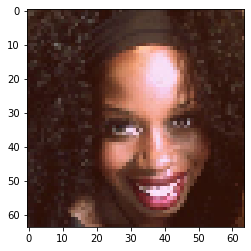

In [111]:
plt.imshow(X_test[14])

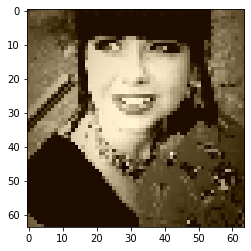

In [112]:
plt.imshow(X_test[15])